In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch import nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import evaluate
from tqdm import tqdm

from helper_functions import ReviewDataset, plot_training, plot_confusion_matrix

2024-06-17 11:41:01.673686: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 11:41:02.458702: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In [18]:
data = pd.read_csv('train_data.csv')
display(data)

,review,rating
0,location not palace excellent hotel booke dthe...,4
1,respite definitely not place stay looking ultr...,3
2,stunning truly memorable spot right beach nusa...,4
3,solid business hotel near embassy stayed hotel...,3
4,nice place make sure lock money warning money ...,3
...,...,...
16387,great base explore new york stayed 4 nights en...,4
16388,wonderful advert paris wonderful introduction ...,4
16389,ideal relaxing holdiay rachel jay green liverp...,3
16390,"watch food, husband went resort 4 nights chris...",2


## Architektura BERT

In [11]:
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
def tokenize(data, tokenizer):
    return tokenizer.encode(data, padding="max_length", truncation=True)

In [13]:
from sklearn.model_selection import train_test_split

train_data, val_data, train_labels, val_labels = train_test_split(data['review'], data['rating'], test_size=0.2, random_state=42)
train_data = train_data.apply(lambda x: tokenize(x, tokenizer))
val_data = val_data.apply(lambda x: tokenize(x, tokenizer))
train_dataset = ReviewDataset(train_data, train_labels)
val_dataset = ReviewDataset(val_data, val_labels)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [23]:
def train(model, train_loader, val_loader, optimizer, criterion, eval_fn, num_epochs=10, device=device, verbose=True):
    loss_hist = []
    train_eval_hist = []
    val_eval_hist = []
    model.to(device)
    for epoch in tqdm(range(num_epochs)):
        model.train()
        total_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            attention_mask = (data != 0).float()
            attention_mask = attention_mask.to(device)
            optimizer.zero_grad()
            output = model(data, attention_mask=attention_mask)[0]
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        loss_hist.append(total_loss)
        train_eval = eval_fn(model, train_loader, device)
        val_eval = eval_fn(model, val_loader, device)
        train_eval_hist.append(train_eval)
        val_eval_hist.append(val_eval)
        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs} Loss: {total_loss}, Train: {train_eval}, Val: {val_eval}")
    return loss_hist, train_eval_hist, val_eval_hist
        
def get_accuracy(model, data_loader, device=device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            attention_mask = (data != 0).float()
            attention_mask = attention_mask.to(device)
            output = model(data, attention_mask=attention_mask)[0]
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct / total

In [14]:
optimizer = Adam(sentiment_model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

loss_hist, train_eval_hist, val_eval_hist = train(sentiment_model, train_loader, val_loader, optimizer, criterion, get_accuracy, num_epochs=5, device=device)

 20%|██        | 1/5 [07:24<29:39, 444.93s/it]

Epoch 1/5 Loss: 1118.2790686935186, Train: 0.8062228323038206, Val: 0.6678865507776761


 40%|████      | 2/5 [14:59<22:32, 450.87s/it]

Epoch 2/5 Loss: 890.9295279085636, Train: 0.8715015633340959, Val: 0.656907593778591


 60%|██████    | 3/5 [22:35<15:05, 452.78s/it]

Epoch 3/5 Loss: 634.8680437933654, Train: 0.9192404484099749, Val: 0.6590423909728576


 80%|████████  | 4/5 [30:09<07:33, 453.48s/it]

Epoch 4/5 Loss: 431.8207607138902, Train: 0.9532524975215435, Val: 0.639219274168954


100%|██████████| 5/5 [37:45<00:00, 453.02s/it]

Epoch 5/5 Loss: 294.0053694623057, Train: 0.9736902310684054, Val: 0.646843549862763


In [15]:
torch.save(sentiment_model.state_dict(), 'sentiment_model.pth')

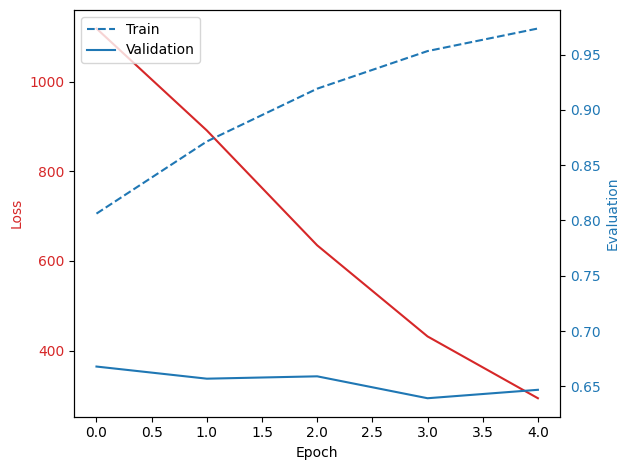

In [16]:
plot_training(loss_hist, train_eval_hist, val_eval_hist)

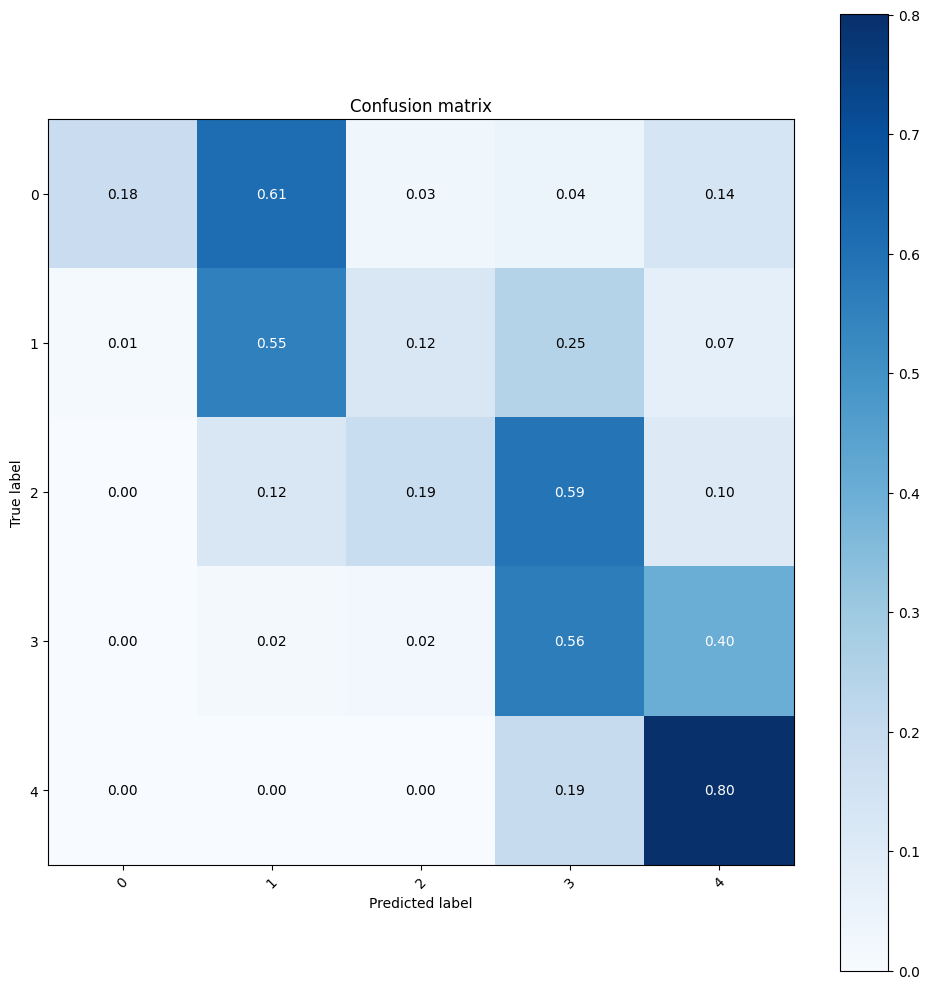

In [17]:
confusion_matrix = evaluate.load('confusion_matrix')
sentiment_model.eval()
with torch.no_grad():
    target_list = []
    output_list = []
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = sentiment_model(data)[0]
        output = torch.argmax(output, dim=1)
        target_list.extend(target.cpu().numpy())
        output_list.extend(output.cpu().numpy())
    confusion_matrix = confusion_matrix.compute(references=target_list, predictions=output_list)
cm = torch.tensor(confusion_matrix["confusion_matrix"])
plot_confusion_matrix(cm, classes=[0, 1, 2, 3, 4])

## Architektura GPT

In [5]:
def train_early_stopping(model, train_loader, val_loader, optimizer, criterion, eval_fn, num_epochs=10, patience=3, delta=0.01, device=device, verbose=True):
    loss_hist = []
    train_eval_hist = []
    val_eval_hist = []
    model.to(device)
    patience_counter = 0
    best_val = 0
    for epoch in tqdm(range(num_epochs)):
        model.train()
        total_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            attention_mask = (data != 0).float()
            output = model(data, attention_mask=attention_mask)[0]
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        loss_hist.append(total_loss)
        train_eval = eval_fn(model, train_loader, device)
        val_eval = eval_fn(model, val_loader, device)
        train_eval_hist.append(train_eval)
        val_eval_hist.append(val_eval)
        if val_eval > best_val + delta:
            best_val = val_eval
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            break
        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs} Loss: {total_loss}, Train: {train_eval}, Val: {val_eval}")
        torch.cuda.empty_cache()
    model.load_state_dict(best_model)
    return loss_hist, train_eval_hist, val_eval_hist

def get_accuracy(model, data_loader, device=device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            attention_mask = (data != 0).float()
            attention_mask = attention_mask.to(device)
            output = model(data, attention_mask=attention_mask)[0]
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct / total

In [6]:
from transformers import AutoTokenizer, OpenAIGPTForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("openai-community/openai-gpt")
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
model = OpenAIGPTForSequenceClassification.from_pretrained("openai-community/openai-gpt", num_labels=5)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = tokenizer.pad_token_id

Some weights of OpenAIGPTForSequenceClassification were not initialized from the model checkpoint at openai-community/openai-gpt and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
from sklearn.model_selection import train_test_split

train_data, val_data, train_labels, val_labels = train_test_split(data['review'], data['rating'], test_size=0.2, random_state=42)
val_data, test_data, val_labels, test_labels = train_test_split(val_data, val_labels, test_size=0.5, random_state=42)
train_data = train_data.apply(lambda x: tokenize(x, tokenizer))
val_data = val_data.apply(lambda x: tokenize(x, tokenizer))
train_dataset = ReviewDataset(train_data, train_labels)
val_dataset = ReviewDataset(val_data, val_labels)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [8]:
optimizer = Adam(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

loss_hist, train_eval_hist, val_eval_hist = train_early_stopping(model, train_loader, val_loader, optimizer, criterion, get_accuracy, num_epochs=10, device=device)

 10%|█         | 1/10 [20:29<3:04:27, 1229.75s/it]

Epoch 1/10 Loss: 3212.8799622021616, Train: 0.6039807824296499, Val: 0.5838926174496645


 20%|██        | 2/10 [41:00<2:44:03, 1230.38s/it]

Epoch 2/10 Loss: 2680.7212833464146, Train: 0.710973842751468, Val: 0.6436851738865161


 30%|███       | 3/10 [1:01:31<2:23:34, 1230.71s/it]

Epoch 3/10 Loss: 2332.4174098074436, Train: 0.7080759551590026, Val: 0.6070774862721171


 40%|████      | 4/10 [1:21:59<2:02:58, 1229.70s/it]

Epoch 4/10 Loss: 2399.5161439813673, Train: 0.4471898116373065, Val: 0.44905430140329466


 40%|████      | 4/10 [1:42:28<2:33:42, 1537.09s/it]


In [10]:
torch.save(model.state_dict(), 'gpt.pth')

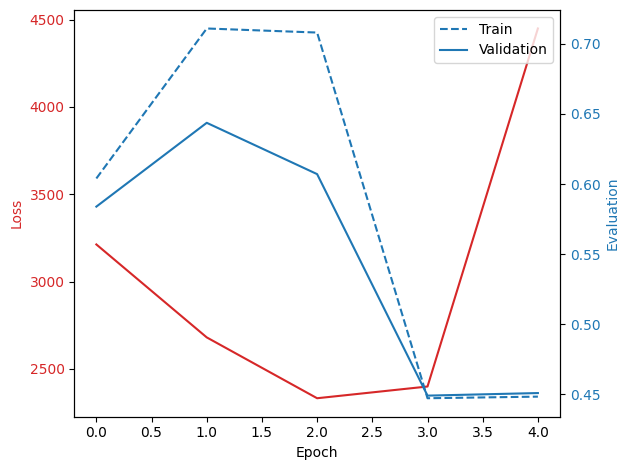

In [11]:
plot_training(loss_hist, train_eval_hist, val_eval_hist)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


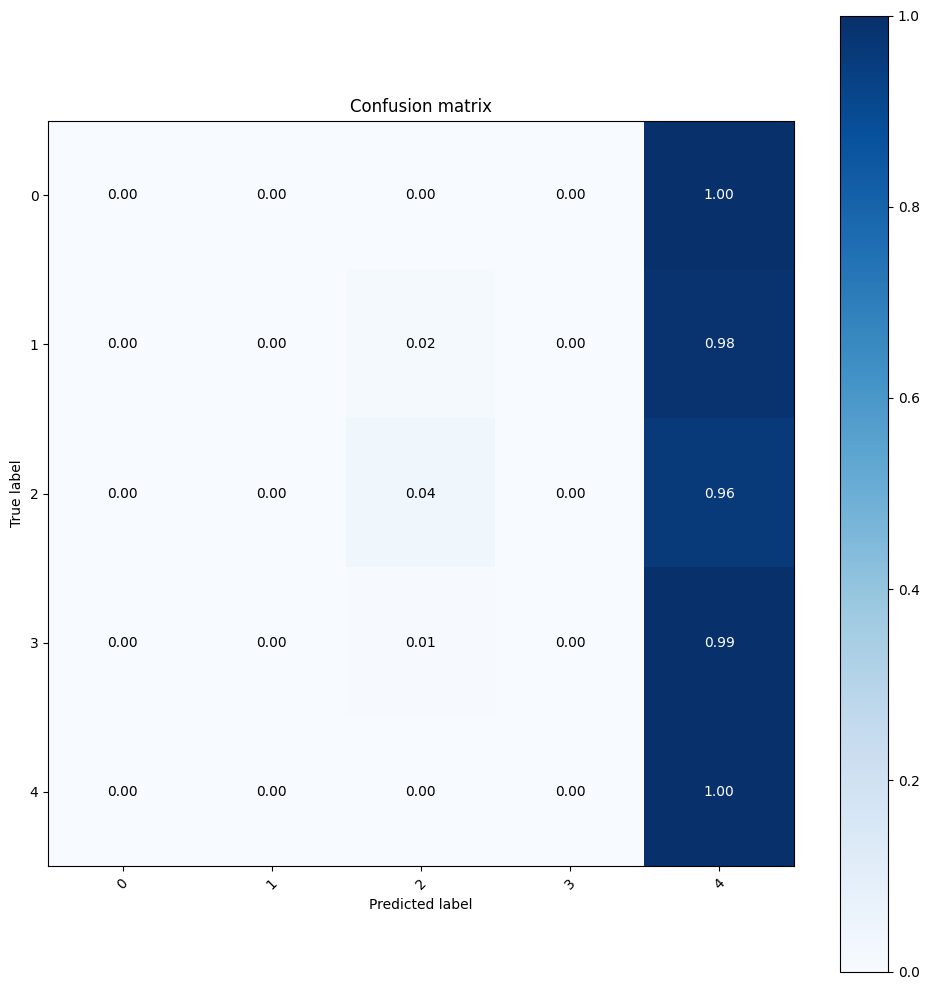

In [12]:
confusion_matrix = evaluate.load('confusion_matrix')
model.eval()
with torch.no_grad():
    target_list = []
    output_list = []
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)[0]
        output = torch.argmax(output, dim=1)
        target_list.extend(target.cpu().numpy())
        output_list.extend(output.cpu().numpy())
    confusion_matrix = confusion_matrix.compute(references=target_list, predictions=output_list)
cm = torch.tensor(confusion_matrix["confusion_matrix"])
plot_confusion_matrix(cm, classes=[0, 1, 2, 3, 4])

In [19]:
from transformers import AutoTokenizer, OpenAIGPTForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("openai-community/openai-gpt")
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
model = OpenAIGPTForSequenceClassification.from_pretrained("openai-community/openai-gpt", num_labels=5)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = tokenizer.pad_token_id

Some weights of OpenAIGPTForSequenceClassification were not initialized from the model checkpoint at openai-community/openai-gpt and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
from sklearn.model_selection import train_test_split

train_data, val_data, train_labels, val_labels = train_test_split(data['review'], data['rating'], test_size=0.2, random_state=42)
val_data, test_data, val_labels, test_labels = train_test_split(val_data, val_labels, test_size=0.5, random_state=42)
train_data = train_data.apply(lambda x: tokenize(x, tokenizer))
val_data = val_data.apply(lambda x: tokenize(x, tokenizer))
train_dataset = ReviewDataset(train_data, train_labels)
val_dataset = ReviewDataset(val_data, val_labels)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [21]:
optimizer = Adam(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

loss_hist, train_eval_hist, val_eval_hist = train_early_stopping(model, train_loader, val_loader, optimizer, criterion, get_accuracy, num_epochs=10, device=device, patience=7)

 10%|█         | 1/10 [18:58<2:50:45, 1138.34s/it]

Epoch 1/10 Loss: 3101.1995932757854, Train: 0.6619385342789598, Val: 0.6327028676021964


 20%|██        | 2/10 [37:47<2:31:01, 1132.70s/it]

Epoch 2/10 Loss: 2679.616229943931, Train: 0.7277510867078472, Val: 0.6571079926784624


 30%|███       | 3/10 [56:36<2:11:59, 1131.30s/it]

Epoch 3/10 Loss: 2471.393110372126, Train: 0.5210859452451766, Val: 0.5076266015863331


 40%|████      | 4/10 [1:15:24<1:53:00, 1130.04s/it]

Epoch 4/10 Loss: 2345.721897408366, Train: 0.8026386029131396, Val: 0.652837095790116


 50%|█████     | 5/10 [1:34:12<1:34:06, 1129.26s/it]

Epoch 5/10 Loss: 1978.2010625591502, Train: 0.7453671928620453, Val: 0.6375838926174496


 60%|██████    | 6/10 [1:53:01<1:15:17, 1129.26s/it]

Epoch 6/10 Loss: 4423.824528172612, Train: 0.4420041180507893, Val: 0.44722391702257475


 70%|███████   | 7/10 [2:11:50<56:26, 1128.97s/it]  

Epoch 7/10 Loss: 4475.99112033844, Train: 0.4420041180507893, Val: 0.44722391702257475


 80%|████████  | 8/10 [2:30:39<37:37, 1128.92s/it]

Epoch 8/10 Loss: 4469.938643634319, Train: 0.4420041180507893, Val: 0.44722391702257475


 80%|████████  | 8/10 [2:49:27<42:21, 1270.88s/it]


In [22]:
torch.save(model.state_dict(), 'gpt2.pth')

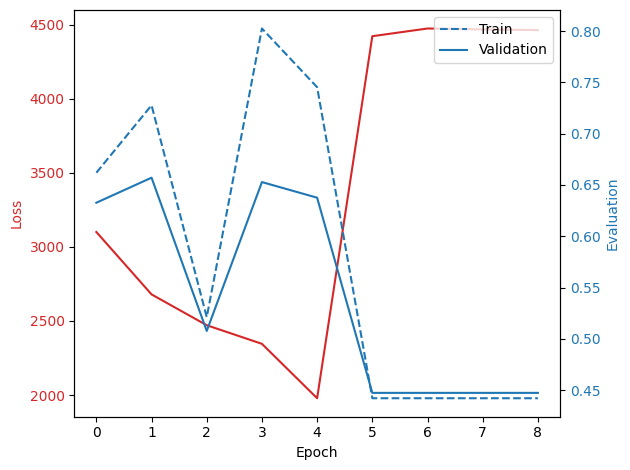

In [23]:
plot_training(loss_hist, train_eval_hist, val_eval_hist)

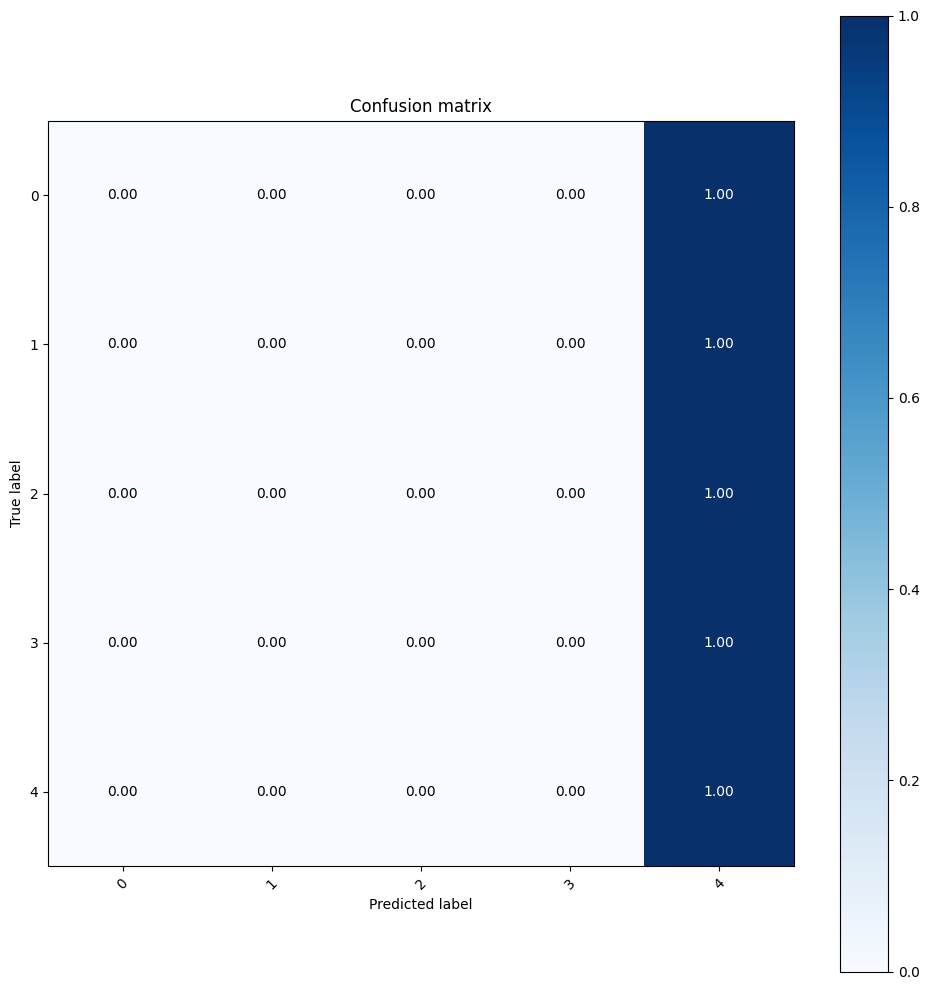

In [24]:
confusion_matrix = evaluate.load('confusion_matrix')
model.eval()
with torch.no_grad():
    target_list = []
    output_list = []
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)[0]
        output = torch.argmax(output, dim=1)
        target_list.extend(target.cpu().numpy())
        output_list.extend(output.cpu().numpy())
    confusion_matrix = confusion_matrix.compute(references=target_list, predictions=output_list)
cm = torch.tensor(confusion_matrix["confusion_matrix"])
plot_confusion_matrix(cm, classes=[0, 1, 2, 3, 4])

## Predykcje

Predykcje zostały wygenerowane za pomocą modelu BERT, gdyż uzyskał najlepsze wyniki

In [15]:
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
final_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)
final_model.load_state_dict(torch.load('sentiment_model.pth'))
final_model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [16]:
def tokenize(data, tokenizer):
    return tokenizer.encode(data, padding="max_length", truncation=True)

In [17]:
test_data = pd.read_csv('test_data.csv', header=None)
test_data = test_data[0]
test_data = test_data.apply(lambda x: tokenize(x, tokenizer))
test_labels = [0 for _ in range(len(test_data))]
test_dataset = ReviewDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [18]:
final_model.eval()
with torch.no_grad():
    target_list = []
    output_list = []
    for data, _ in test_loader:
        data = data.to(device)
        attention_mask = (data != 0).float()
        attention_mask = attention_mask.to(device)
        output = final_model(data, attention_mask=attention_mask)[0]
        output = torch.argmax(output, dim=1)
        output_list.extend(output.cpu().numpy())
res = pd.DataFrame(output_list)
res.to_csv('results.csv', index=False, header=False)